In [1]:
print('load libraries')
import xarray as xr
import numpy as np
import dask
from tqdm import tqdm
import pandas as pd
import xwmb
import regionate as reg
import xwmt
import xgcm
import warnings
warnings.filterwarnings('ignore')
import cftime

import matplotlib.pyplot as plt

reg.__version__, xwmb.__version__, xwmt.__version__, xgcm.__version__

load libraries


('0.0.1', '0.1.0', '0.1.1', '0.8.2.dev15+g7492277')

In [ ]:
hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/data_daily/"
mt_path = "/pub/mariant3/WarmWaterMasses/data/"

ds = xr.open_mfdataset(
    f"{hfdrake_path}/*.ocean_daily.*.nc",chunks={"time":1}
)
snap = xr.open_mfdataset(
    f"{hfdrake_path}/*.ocean_daily_snap*.nc", chunks={"time":1}
)
static = xr.open_dataset(
    "/pub/hfdrake/datasets/CM4_MHW_blobs/data/WMT_monthly/ocean_month_rho2.static.nc"
)

#Merge snapshots with time-averages
snap = snap.rename({
    **{'time': 'time_bounds'},
    **{v: f"{v}_bounds" for v in snap.data_vars}
    })

ocetrac_labels = xr.open_dataset(
    f"{mt_path}/ocetracv9/ocetrac-v9-blobs-tos-t1-r1-msq0-01860315-01891214-region.nc", chunks={'time':1}
)

labels = (ocetrac_labels
          .sel(time=slice("0186","0186"))
          .blobs
          .rename('event_mask')
          .load()
         )

In [25]:
ids = np.unique(labels)
ids = np.array([id for id in ids if ~np.isnan(id)])
one_day_ids = [mhw for mhw in ids if len(labels.where(labels == mhw, drop=True).time) == 1]
ids = np.array([id for id in ids if id not in one_day_ids])

mhw = 373

print('----------------- starting cumulative mask part -----------------')

event = (labels == mhw).any("time")
ds_event = xr.merge([ds, event], join="inner")
ds_event = xr.merge([ds_event.sel(time=ds_event.time[1:]), snap])
ds_event = xr.merge([static, ds_event], join='inner')
ds_event["event_mask"] = ds_event.event_mask.fillna(0.) # need to set the NaN values in the mask to zero!

def add_estimated_layer_interfaces(ds):
    return ds.assign_coords({"zi": xr.DataArray(
        np.concatenate([[0], 0.5*(ds.zl.values[1:]+ds.zl.values[0:-1]), [6000]]),
        dims=('zi',)
    )})

ds_event = add_estimated_layer_interfaces(ds_event)

print('----------------- Adding core coordinates of static to ds_event -----------------')

ds_event = ds_event.assign_coords({
    "areacello": xr.DataArray(ds_event["areacello"].values, dims=('yh', 'xh',)), # Required for area-integration
    "lon": xr.DataArray(ds_event["geolon"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "lat": xr.DataArray(ds_event["geolat"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "xq": xr.DataArray(ds_event["xq"].values, dims=('xq',)),
    "yq": xr.DataArray(ds_event["yq"].values, dims=('yq',)),
    "deptho": xr.DataArray(ds_event["deptho"].values, dims=('yh', 'xh',)),
    "geolon": xr.DataArray(ds_event["geolon"].values, dims=('yh', 'xh',)),
    "geolat": xr.DataArray(ds_event["geolat"].values, dims=('yh', 'xh',)),
    "geolon_c": xr.DataArray(ds_event["geolon_c"].values, dims=('yq', 'xq',)),
    "geolat_c": xr.DataArray(ds_event["geolat_c"].values, dims=('yq', 'xq',)),
})
coords = {
'X': {'center': 'xh', 'outer': 'xq'},
'Y': {'center': 'yh', 'outer': 'yq'},
'Z': {'center': 'zl', 'outer': 'zi'}
}
metrics = {
    ('X','Y'): "areacello", # Required for area-integration
}

ds_event['tos'] = ds_event['thetao'].isel(zl=0)
grid = xgcm.Grid(ds_event.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)
wm = xwmt.WaterMass(grid)

print('----------------- importing xbudget -----------------')

import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly").copy()
del budgets_dict['salt']['lhs']
del budgets_dict['salt']['rhs']

xbudget.collect_budgets(grid, budgets_dict)

----------------- starting cumulative mask part -----------------
----------------- Adding core coordinates of static to ds_event -----------------
----------------- importing xbudget -----------------


In [26]:
print('----------------- get start and end dates for a particular event -----------------')

start_event_date = labels.where(labels==mhw,drop=True).time.values.astype('datetime64[D]')[0]
start_event = grid._ds.get_index("time").get_loc(f"{start_event_date}").start

end_event_date = labels.where(labels==mhw,drop=True).time.values.astype('datetime64[D]')[-1]
end_event = grid._ds.get_index("time").get_loc(f"{end_event_date}").start

print(f'Event {mhw} starts on {start_event_date} index={start_event} and ends on {end_event_date},index={end_event}')

----------------- get start and end dates for a particular event -----------------
Event 373 starts on 0186-04-30 index=118 and ends on 0186-10-22,index=293


In [27]:
print('----------------- getting ready for heat budget calculation -----------------')
aggregated_budget = xbudget.aggregate(budgets_dict)["heat"]

heat_budget = xr.Dataset()
for k,v in aggregated_budget.items():
    if type(v)!=dict: continue
    for label, varname in v.items():
        if "surface_ocean_flux_advective_negative" in label: continue # because these cancel out anyways
        if (k == "lhs") and (label != "Eulerian_tendency"):
            heat_budget[label] = -1*grid._ds[varname]
        else:
            heat_budget[label] = grid._ds[varname]

----------------- getting ready for heat budget calculation -----------------


### Approach 1. Integrating heat tendencies over the same warm water mask as in the water mass budget calculations

We apply two masks: the two-dimensional (X,Y) cumulative mask for the event and the four-dimensional (X,Y,Z,T) mask of where temperatures are larger than 29ºC.

In [28]:
def integrate_heat_budget(heat_budget, ds):
    """Computes the volume integral of a heat budget dataset.
    
    Because heat budget terms derived by xbudget have already been integrated vertically
    (when diagnosed from MOM6) and integrated over the horizontal area of grid cells by
    the xbudget.collect method, we just need to apply a mask for the volume of water
    that we define as part of the event and sum over all spatial dimensions.

    See https://github.com/hdrake/xbudget for examples of how the heat budget is structured
    in MOM6, and how the xbudget package can be used to manipulate these terms.
    """
    temperature_mask = ds.thetao >= 29.
    event_and_temperature_mask = np.logical_and(ds.event_mask, temperature_mask)
    return heat_budget.where(event_and_temperature_mask).sum(["xh", "yh", "zl"])

In [29]:
heat_budget_event = integrate_heat_budget(heat_budget, grid._ds).isel(time=slice(start_event-5, end_event+5))

print('----------------- loading heat budget calculation -----------------')
display(heat_budget_event)
heat_budget_event.load()
print('done with wmt_event.load()')

----------------- loading heat budget calculation -----------------


<xarray.Dataset>
Dimensions:                (time: 185)
Coordinates:
  * time                   (time) object 0186-04-25 12:00:00 ... 0186-10-26 1...
Data variables:
    Eulerian_tendency      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    advection              (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    diffusion              (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    surface_exchange_flux  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    bottom_flux            (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    frazil_ice             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

done with wmt_event.load()


In [23]:
# heat_budget_event.to_netcdf(f'/pub/mariant3/WarmWaterMasses/data/budgets/heat_budgets/heat-budget-id-373-full-column.nc', mode='w')

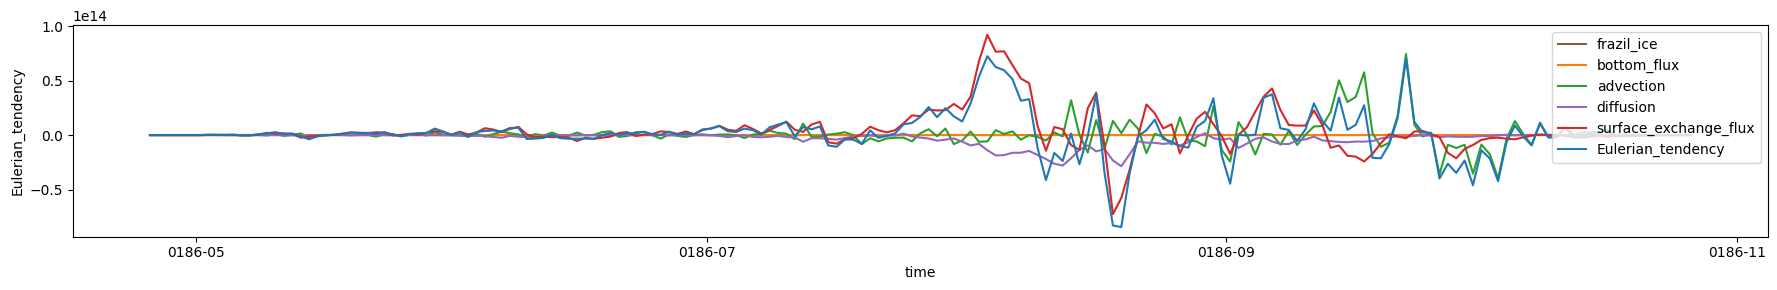

In [30]:
plt.figure(figsize=(18,3))
heat_budget_event.frazil_ice.plot(label="frazil_ice", color="C5")
heat_budget_event.bottom_flux.plot(label="bottom_flux", color="C1")
heat_budget_event.advection.plot(label="advection", color="C2")
heat_budget_event.diffusion.plot(label="diffusion", color="C4")
heat_budget_event.surface_exchange_flux.plot(label="surface_exchange_flux", color="C3")
heat_budget_event.Eulerian_tendency.plot(label="Eulerian_tendency", color="C0")
plt.legend()
plt.tight_layout()
# plt.savefig("/pub/mariant3/WarmWaterMasses/figures/heat-budget-example-event-373.png", dpi=300)
plt.show()

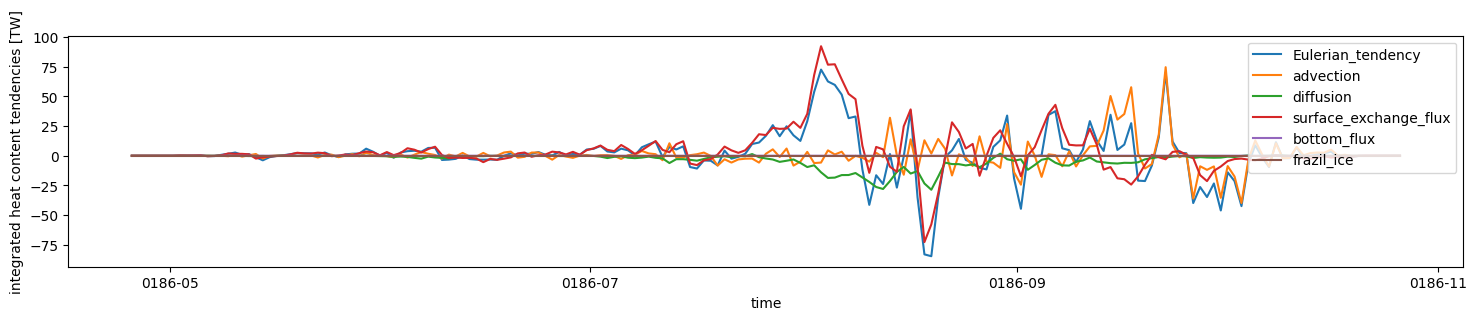

In [31]:
plt.figure(figsize=(18,3))
for v in heat_budget_event.data_vars:
    (heat_budget_event[v]*1e-12).plot(label=v)
plt.ylabel("integrated heat content tendencies [TW]")
plt.legend()

### Approach 2. Integrating heat tendencies over the top 10m and the fixed cumulative horizontal mask

We apply two masks: the two-dimensional (X,Y) cumulative mask for the event and the four-dimensional (X,Y,Z,T) mask of where temperatures are larger than 29ºC.

In [32]:
grid._ds["z"] = wm.grid._ds.z
grid._ds["z_interface"] = wm.grid._ds.z

heat_budget_10m = xr.Dataset(coords={"time": heat_budget.time})

for k in heat_budget.data_vars:
    heat_budget_10m[k] = grid.transform(
        heat_budget[k],
        "Z",
        target = xr.DataArray(np.array([0, 10]), dims=('z_i',)),
        target_data = -grid._ds["z_interface"],
        method="conservative"
    ).rename({"z_i":"z_l"}).sum(["xh", "yh", "z_l"])

heat_budget_event_10m = heat_budget_10m.isel(time=slice(start_event-5, end_event+5)).compute()

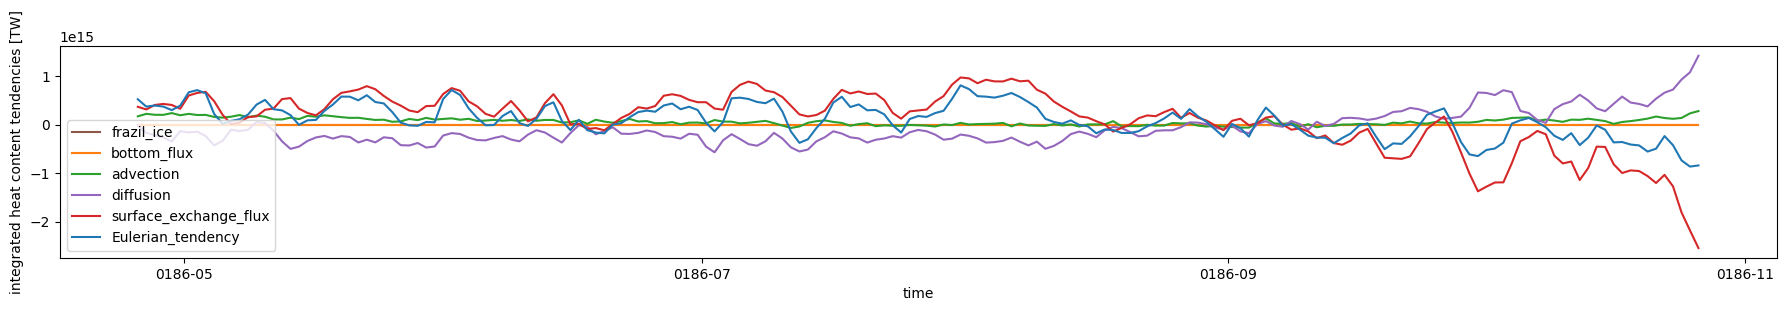

In [33]:
plt.figure(figsize=(18,3))
heat_budget_event_10m.frazil_ice.plot(label="frazil_ice", color="C5")
heat_budget_event_10m.bottom_flux.plot(label="bottom_flux", color="C1")
heat_budget_event_10m.advection.plot(label="advection", color="C2")
heat_budget_event_10m.diffusion.plot(label="diffusion", color="C4")
heat_budget_event_10m.surface_exchange_flux.plot(label="surface_exchange_flux", color="C3")
heat_budget_event_10m.Eulerian_tendency.plot(label="Eulerian_tendency", color="C0")
plt.ylabel("integrated heat content tendencies [TW]")
plt.legend()
plt.tight_layout()
# plt.savefig("/pub/mariant3/WarmWaterMasses/figures/heat-budget10m-example-event-373.png", dpi=300)
plt.show()

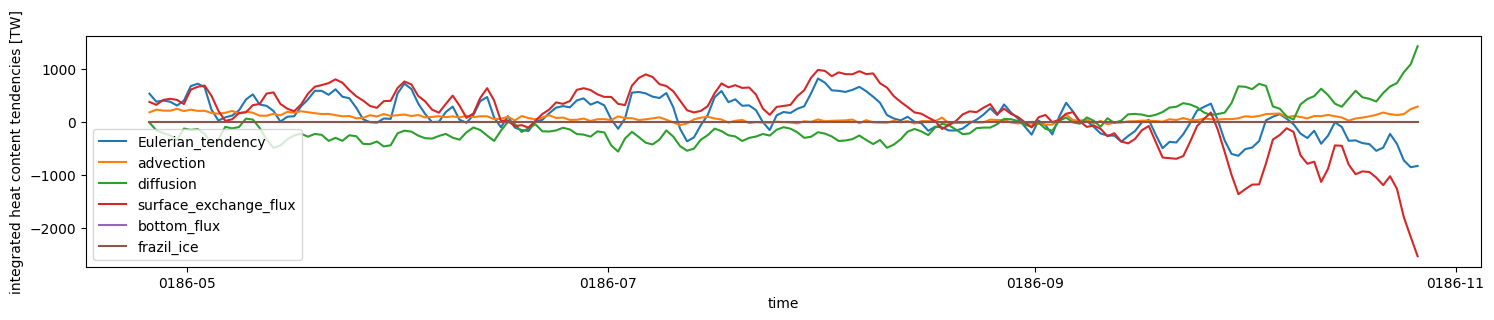

In [34]:
plt.figure(figsize=(18,3))
for v in heat_budget_event_10m.data_vars:
    (heat_budget_event_10m[v]*1e-12).plot(label=v)
plt.ylabel("integrated heat content tendencies [TW]")
plt.legend();

In [24]:
# heat_budget_event_10m.to_netcdf(f'/pub/mariant3/WarmWaterMasses/data/budgets/heat_budgets/heat-budget-id-373-10m.nc', mode='w')